# Import Libraries

In [289]:
import pymc as pm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Open Data

In [290]:
df = pd.read_csv("data/Spotify_Songs_Cleaned.csv", encoding="latin1")

In [291]:
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,day_of_week,Full Key
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,Major,80,89,83,31,0,8,4,Friday,B Major
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,Major,71,61,74,7,0,10,4,Thursday,C# Major
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,Major,51,32,53,17,0,31,6,Friday,F Major
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,Major,55,58,72,11,0,11,15,Friday,A Major
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,Minor,65,23,80,14,63,11,6,Thursday,A Minor


In [292]:
df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
       'day_of_week', 'Full Key'],
      dtype='object')

In [293]:
df.dtypes

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists     float64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
day_of_week              object
Full Key                 object
dtype: object

# Single Variable Regression

This portion of the analysis asks if any single variable in isolation can predict the number of streams for a song.

In [294]:
x_1var_numeric_reg=df.drop(columns=['track_name','artist(s)_name','key','mode','day_of_week','Full Key','streams'])
y=df['streams']
results_numeric=[]

In [295]:
for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric.append({
        'feature': col,
        'lin_coef': model.coef_[0],
        'lin_intercept': model.intercept_,
        'lin_r2': r2_score(y_test, y_pred),
        'lin_mse': mean_squared_error(y_test,y_pred)
    })

results_df_lin = pd.DataFrame(results_numeric).sort_values(by='lin_r2', ascending=False)
print(results_df_lin)

                 feature      lin_coef  lin_intercept    lin_r2       lin_mse
4   in_spotify_playlists  2.610868e+08   3.615634e+08  0.645982  5.928357e+16
6     in_apple_playlists  2.232191e+08   3.615634e+08  0.562309  7.329527e+16
8    in_deezer_playlists  2.491812e+08   3.615634e+08  0.518198  8.068203e+16
7        in_apple_charts  8.127240e+07   3.615634e+08  0.064151  1.567162e+17
9       in_deezer_charts  9.684745e+07   3.615634e+08  0.063743  1.567847e+17
5      in_spotify_charts  8.998912e+07   3.615634e+08  0.011340  1.655599e+17
18         speechiness_% -2.170131e+07   3.615634e+08  0.009686  1.658369e+17
1          released_year -4.877651e+07   3.615634e+08  0.009196  1.659190e+17
0           artist_count -3.258565e+07   3.615634e+08  0.003364  1.668955e+17
13             valence_% -2.739640e+07   3.615634e+08  0.000849  1.673167e+17
12        danceability_% -3.153226e+07   3.615634e+08 -0.003622  1.680655e+17
10      in_shazam_charts  1.331855e+07   3.615634e+08 -0.004977 

In [296]:
results_numeric_ridge=[]

for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Ridge()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric_ridge.append({
        'feature': col,
        'ridge_coef': model.coef_[0],
        'ridge_intercept': model.intercept_,
        'ridge_r2': r2_score(y_test, y_pred),
        'ridge_mse': mean_squared_error(y_test,y_pred)
    })

results_df_ridge = pd.DataFrame(results_numeric_ridge).sort_values(by='ridge_r2', ascending=False)
print(results_df_ridge)

                 feature    ridge_coef  ridge_intercept  ridge_r2  \
4   in_spotify_playlists  2.606510e+08     3.615634e+08  0.645864   
6     in_apple_playlists  2.228464e+08     3.615634e+08  0.562021   
8    in_deezer_playlists  2.487652e+08     3.615634e+08  0.518420   
7        in_apple_charts  8.113672e+07     3.615634e+08  0.064086   
9       in_deezer_charts  9.668577e+07     3.615634e+08  0.063715   
5      in_spotify_charts  8.983889e+07     3.615634e+08  0.011403   
18         speechiness_% -2.166508e+07     3.615634e+08  0.009665   
1          released_year -4.869508e+07     3.615634e+08  0.009207   
0           artist_count -3.253125e+07     3.615634e+08  0.003356   
13             valence_% -2.735066e+07     3.615634e+08  0.000846   
12        danceability_% -3.147962e+07     3.615634e+08 -0.003615   
10      in_shazam_charts  1.329631e+07     3.615634e+08 -0.004977   
16    instrumentalness_%  1.433633e+06     3.615634e+08 -0.005223   
17            liveness_% -1.536952

In [297]:
results_numeric_lasso=[]

for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric_lasso.append({
        'feature': col,
        'lasso_coef': model.coef_[0],
        'lasso_intercept': model.intercept_,
        'lasso_r2': r2_score(y_test, y_pred),
        'lasso_mse': mean_squared_error(y_test,y_pred)
    })

results_df_lasso = pd.DataFrame(results_numeric_lasso).sort_values(by='lasso_r2', ascending=False)
print(results_df_lasso)

                 feature    lasso_coef  lasso_intercept  lasso_r2  \
4   in_spotify_playlists  2.610868e+08     3.615634e+08  0.645982   
6     in_apple_playlists  2.232191e+08     3.615634e+08  0.562309   
8    in_deezer_playlists  2.491812e+08     3.615634e+08  0.518198   
7        in_apple_charts  8.127240e+07     3.615634e+08  0.064151   
9       in_deezer_charts  9.684745e+07     3.615634e+08  0.063743   
5      in_spotify_charts  8.998912e+07     3.615634e+08  0.011340   
18         speechiness_% -2.170131e+07     3.615634e+08  0.009686   
1          released_year -4.877651e+07     3.615634e+08  0.009196   
0           artist_count -3.258565e+07     3.615634e+08  0.003364   
13             valence_% -2.739639e+07     3.615634e+08  0.000849   
12        danceability_% -3.153226e+07     3.615634e+08 -0.003622   
10      in_shazam_charts  1.331855e+07     3.615634e+08 -0.004977   
16    instrumentalness_%  1.436029e+06     3.615634e+08 -0.005222   
17            liveness_% -1.539522

In [298]:
results_df=pd.merge(results_df_lin,results_df_ridge,on='feature')
results_df=pd.merge(results_df,results_df_lasso,on='feature')
results_df.head(n=20).sort_values(by='lin_r2',ascending=False)

,feature,lin_coef,lin_intercept,lin_r2,lin_mse,ridge_coef,ridge_intercept,ridge_r2,ridge_mse,lasso_coef,lasso_intercept,lasso_r2,lasso_mse
0,in_spotify_playlists,2.610868e+08,3.615634e+08,0.645982,5.928357e+16,2.606510e+08,3.615634e+08,0.645864,5.930331e+16,2.610868e+08,3.615634e+08,0.645982,5.928357e+16
1,in_apple_playlists,2.232191e+08,3.615634e+08,0.562309,7.329527e+16,2.228464e+08,3.615634e+08,0.562021,7.334353e+16,2.232191e+08,3.615634e+08,0.562309,7.329527e+16
2,in_deezer_playlists,2.491812e+08,3.615634e+08,0.518198,8.068203e+16,2.487652e+08,3.615634e+08,0.518420,8.064488e+16,2.491812e+08,3.615634e+08,0.518198,8.068203e+16
3,in_apple_charts,8.127240e+07,3.615634e+08,0.064151,1.567162e+17,8.113672e+07,3.615634e+08,0.064086,1.567271e+17,8.127240e+07,3.615634e+08,0.064151,1.567162e+17
4,in_deezer_charts,9.684745e+07,3.615634e+08,0.063743,1.567847e+17,9.668577e+07,3.615634e+08,0.063715,1.567894e+17,9.684745e+07,3.615634e+08,0.063743,1.567847e+17
5,in_spotify_charts,8.998912e+07,3.615634e+08,0.011340,1.655599e+17,8.983889e+07,3.615634e+08,0.011403,1.655494e+17,8.998912e+07,3.615634e+08,0.011340,1.655599e+17
6,speechiness_%,-2.170131e+07,3.615634e+08,0.009686,1.658369e+17,-2.166508e+07,3.615634e+08,0.009665,1.658404e+17,-2.170131e+07,3.615634e+08,0.009686,1.658369e+17
7,released_year,-4.877651e+07,3.615634e+08,0.009196,1.659190e+17,-4.869508e+07,3.615634e+08,0.009207,1.659171e+17,-4.877651e+07,3.615634e+08,0.009196,1.659190e+17
8,artist_count,-3.258565e+07,3.615634e+08,0.003364,1.668955e+17,-3.253125e+07,3.615634e+08,0.003356,1.668970e+17,-3.258565e+07,3.615634e+08,0.003364,1.668955e+17
9,valence_%,-2.739640e+07,3.615634e+08,0.000849,1.673167e+17,-2.735066e+07,3.615634e+08,0.000846,1.673173e+17,-2.739639e+07,3.615634e+08,0.000849,1.673167e+17


In [299]:
categorical_features = ['day_of_week', 'key','mode','Full Key']
results_cat = []

for cat in categorical_features:
    X_cat = pd.get_dummies(df[cat], drop_first=True)  #one-hot encoding, need to drop_first for linear regression

    X_train, X_test, y_train, y_test = train_test_split(
        X_cat, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    for i, dummy_col in enumerate(X_cat.columns):
        results_cat.append({
            'feature': f"{cat}_{dummy_col}",
            'lin_coef': model.coef_[i],
            'lin_intercept': model.intercept_,
            'lin_r2': r2_score(y_test, y_pred),
            'lin_mse': mean_squared_error(y_test,y_pred)
        })

results_cat_df = pd.DataFrame(results_cat).sort_values(by='lin_r2', ascending=True)
print(results_cat_df)


                  feature      lin_coef  lin_intercept    lin_r2       lin_mse
24       Full Key_D Major  2.027913e+07   3.615634e+08 -0.043664  1.747708e+17
31       Full Key_F Minor -2.602059e+06   3.615634e+08 -0.043664  1.747708e+17
29       Full Key_E Minor -8.838241e+06   3.615634e+08 -0.043664  1.747708e+17
30       Full Key_F Major  1.912185e+07   3.615634e+08 -0.043664  1.747708e+17
27      Full Key_D# Minor -1.238430e+07   3.615634e+08 -0.043664  1.747708e+17
26      Full Key_D# Major -3.786377e+06   3.615634e+08 -0.043664  1.747708e+17
25       Full Key_D Minor -6.747889e+06   3.615634e+08 -0.043664  1.747708e+17
28       Full Key_E Major  1.734807e+07   3.615634e+08 -0.043664  1.747708e+17
20       Full Key_B Major -1.603414e+07   3.615634e+08 -0.043664  1.747708e+17
23      Full Key_C# Minor  2.087353e+07   3.615634e+08 -0.043664  1.747708e+17
21       Full Key_B Minor  2.399021e+07   3.615634e+08 -0.043664  1.747708e+17
22      Full Key_C# Major  1.030531e+07   3.615634e+

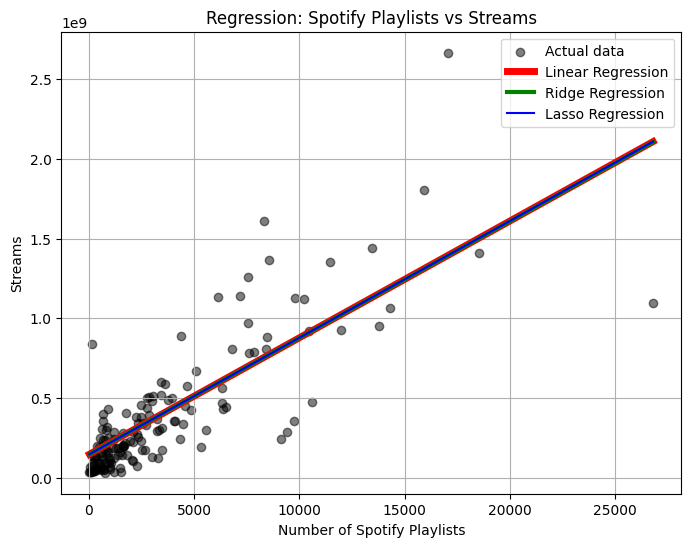

In [300]:
X = df[['in_spotify_playlists']]
y = df['streams']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_lin = model.predict(X_test_scaled)

model= Ridge()
model.fit(X_train_scaled, y_train)
y_pred_ridge = model.predict(X_test_scaled)

model= Lasso()
model.fit(X_train_scaled, y_train)
y_pred_lasso = model.predict(X_test_scaled)

#sorted for clean line plotting
sorted_idx = np.argsort(X_test.values.flatten())
X_test_sorted = X_test.values.flatten()[sorted_idx]
y_pred_lin_sorted = y_pred_lin[sorted_idx]
y_pred_ridge_sorted = y_pred_ridge[sorted_idx]
y_pred_lasso_sorted = y_pred_lasso[sorted_idx]

#plotting code
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual data',color='black')
plt.plot(X_test_sorted, y_pred_lin_sorted, color='red', label='Linear Regression',lw=5)
plt.plot(X_test_sorted, y_pred_ridge_sorted, color='green', label='Ridge Regression',lw=3)
plt.plot(X_test_sorted, y_pred_lasso_sorted, color='blue', label='Lasso Regression')

plt.xlabel('Number of Spotify Playlists')
plt.ylabel('Streams')
plt.title('Regression: Spotify Playlists vs Streams')
plt.legend()
plt.grid(True)
plt.show()


For single variable regression, each variable was compared independently with Linear, Ridge, and Lasso Regression. As shown by the results_df table, all of the values across each single feature were nearly identical. This makes sense because with only one predictor each model becomes nearly identical and the regularization components of Ridge and Lasso Regression don't come into effect. Bayesian regression wasn't included in this analysis because with only one predictor, the Bayesian posterior mean with Gaussian priors would match the frequentist values in the other regression models. 

Through this single-variable analysis, it was determined that the feature that had the highest r2 score (approximately .646) and smallest MSE was Spotify playlists. This makes sense because the streams are collected on the Spotify platform. The graph above also shows an interesting feature of our data that it is highly concentrated for spotify playlists under 15,000. This means with only a few outlier points of the hundreds of data points in our set, they don't have much of an influence on slope of the regression line.

Interestingly, when analyzed independently the one-hot encoded categorical variables for the day_of_the_week, released_month, and full_key (includes key and mode) all had negative R2 scores when linear regression was applied to the data. The negative R2 scores indicate that predicting with these features alone performs worse than just predicting the mean value of streams. These negative scores could be a result of them being features that we engineered or also because there are some innate dependencies that are unable to be captured with single-variable analysis.

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [301]:
x_mvar_numeric=df.drop(columns=['track_name','artist(s)_name','key','mode','day_of_week','Full Key','streams'])
y=df['streams']

In [401]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_model = LinearRegression()
lin_model.fit(X_train_scaled,y_train)
y_pred = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
    'lin_intercept': lin_model.intercept_,
    'lin_r2': r2_score(y_test, y_pred),
    'lin_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lin)

                 feature      lin_coef  lin_intercept    lin_r2       lin_mse
0           artist_count -1.948513e+07   3.615634e+08  0.719576  4.695959e+16
1          released_year  2.144860e+07   3.615634e+08  0.719576  4.695959e+16
2         released_month  1.916520e+07   3.615634e+08  0.719576  4.695959e+16
3           released_day  2.255076e+07   3.615634e+08  0.719576  4.695959e+16
4   in_spotify_playlists  1.305335e+08   3.615634e+08  0.719576  4.695959e+16
5      in_spotify_charts  7.641678e+07   3.615634e+08  0.719576  4.695959e+16
6     in_apple_playlists  5.332033e+07   3.615634e+08  0.719576  4.695959e+16
7        in_apple_charts  8.205632e+06   3.615634e+08  0.719576  4.695959e+16
8    in_deezer_playlists  1.079620e+08   3.615634e+08  0.719576  4.695959e+16
9       in_deezer_charts  3.627089e+06   3.615634e+08  0.719576  4.695959e+16
10      in_shazam_charts -7.041046e+07   3.615634e+08  0.719576  4.695959e+16
11                   bpm  2.842647e+06   3.615634e+08  0.719576 

In [399]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled,y_train)
y_pred = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
    'ridge_intercept': ridge_model.intercept_,
    'ridge_r2': r2_score(y_test, y_pred),
    'ridge_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_ridge)

                 feature    ridge_coef  ridge_intercept  ridge_r2  \
0           artist_count -1.945604e+07     3.615634e+08  0.719567   
1          released_year  2.133333e+07     3.615634e+08  0.719567   
2         released_month  1.915470e+07     3.615634e+08  0.719567   
3           released_day  2.252911e+07     3.615634e+08  0.719567   
4   in_spotify_playlists  1.302922e+08     3.615634e+08  0.719567   
5      in_spotify_charts  7.608004e+07     3.615634e+08  0.719567   
6     in_apple_playlists  5.342406e+07     3.615634e+08  0.719567   
7        in_apple_charts  8.266094e+06     3.615634e+08  0.719567   
8    in_deezer_playlists  1.078633e+08     3.615634e+08  0.719567   
9       in_deezer_charts  3.711949e+06     3.615634e+08  0.719567   
10      in_shazam_charts -7.013586e+07     3.615634e+08  0.719567   
11                   bpm  2.818770e+06     3.615634e+08  0.719567   
12        danceability_% -5.673366e+06     3.615634e+08  0.719567   
13             valence_% -5.363844

In [400]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso()
lasso_model.fit(X_train_scaled,y_train)
y_pred = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
    'lasso_intercept': lasso_model.intercept_,
    'lasso_r2': r2_score(y_test, y_pred),
    'lasso_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lasso)

                 feature    lasso_coef  lasso_intercept  lasso_r2  \
0           artist_count -1.948513e+07     3.615634e+08  0.719576   
1          released_year  2.144860e+07     3.615634e+08  0.719576   
2         released_month  1.916520e+07     3.615634e+08  0.719576   
3           released_day  2.255076e+07     3.615634e+08  0.719576   
4   in_spotify_playlists  1.305335e+08     3.615634e+08  0.719576   
5      in_spotify_charts  7.641677e+07     3.615634e+08  0.719576   
6     in_apple_playlists  5.332033e+07     3.615634e+08  0.719576   
7        in_apple_charts  8.205631e+06     3.615634e+08  0.719576   
8    in_deezer_playlists  1.079620e+08     3.615634e+08  0.719576   
9       in_deezer_charts  3.627088e+06     3.615634e+08  0.719576   
10      in_shazam_charts -7.041046e+07     3.615634e+08  0.719576   
11                   bpm  2.842646e+06     3.615634e+08  0.719576   
12        danceability_% -5.694525e+06     3.615634e+08  0.719576   
13             valence_% -5.343318

In [ ]:
with pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_bad_model:  #model specifications in PyMC are wrapped in a with-statement
    #define priors like equation 5.56 in textbook (non-informative)
    sigma = pm.HalfFlat("sigma")

    intercept = pm.Flat("Intercept")
    slope = pm.Flat("slope", dims="predictors")

    mu = intercept + pm.math.dot(x_mvar_numeric.values, slope)

    likelihood = pm.Normal(
        "streams",
        mu=mu,
        sigma=sigma,
        observed=y.values
    )

In [306]:
"""
pm.model_to_graphviz(multivar_bad_model)

with multivar_bad_model:
    prior_samples = pm.sample_prior_predictive(100)
    """

'\npm.model_to_graphviz(multivar_bad_model)\n\nwith multivar_bad_model:\n    prior_samples = pm.sample_prior_predictive(100)\n    '

These calls above don't work because it is a non-informative prior, telling us that we can't inform anything from it. Now, let's test when we have a weakly-informative Gaussian prior, which should be close to regular regression models.

In [307]:
x_mvar_numeric.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,1.584225,2019.462567,6.153743,13.947861,3065.844920,10.875668,48.965241,46.905080,93.549465,2.368984,48.909091,123.143048,67.592246,51.129679,64.137701,26.700535,1.681818,18.304813,10.711230
std,0.893000,10.248581,3.513470,9.110284,3715.184068,17.915667,57.452117,48.617958,155.906011,5.316258,124.329225,28.333491,14.585603,23.607864,15.933631,25.190809,8.838448,13.722069,10.332208
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2021.000000,3.000000,6.000000,792.500000,0.000000,11.000000,6.000000,12.000000,0.000000,0.000000,100.000000,58.000000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,5.000000,13.000000,1785.500000,2.000000,27.000000,29.000000,32.000000,0.000000,2.000000,121.000000,70.000000,51.000000,65.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,10.000000,22.000000,3771.500000,15.000000,67.000000,79.250000,99.000000,1.000000,33.000000,142.000000,79.000000,70.000000,76.000000,41.250000,0.000000,24.000000,12.000000
max,8.000000,2023.000000,12.000000,31.000000,29499.000000,147.000000,492.000000,275.000000,964.000000,45.000000,953.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


From the summary statistics, all the variances are quite small except for Spotify playlists which has a standard deviation of 3715.18 and a mean of 3065.84 compared to all of the other values which are low in comparison.

In [308]:
"""
with pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=1e4)
    slope_prior_sd =  x_mvar_numeric.std().values * 0.5
    slope = pm.Normal("slope", mu=0, sigma=slope_prior_sd, shape=x_mvar_numeric.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1e4)
    
    mu = intercept + pm.math.dot(x_mvar_numeric.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y.values)
    """

'\nwith pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_model:\n    intercept = pm.Normal("Intercept", mu=0, sigma=1e4)\n    slope_prior_sd =  x_mvar_numeric.std().values * 0.5\n    slope = pm.Normal("slope", mu=0, sigma=slope_prior_sd, shape=x_mvar_numeric.shape[1])\n    sigma = pm.HalfNormal("sigma", sigma=1e4)\n\n    mu = intercept + pm.math.dot(x_mvar_numeric.values, slope)\n    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y.values)\n    '

In [333]:
x_scaled = (x_mvar_numeric - x_mvar_numeric.mean()) / x_mvar_numeric.std()
y_scaled= (y - y.mean()) / y.std() #scale down y-values as well for faster computation time

with pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_weak_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, shape=x_scaled.shape[1],dims='predictors')
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = intercept + pm.math.dot(x_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

In [334]:
with multivar_weak_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [Intercept, sigma, slope, streams]


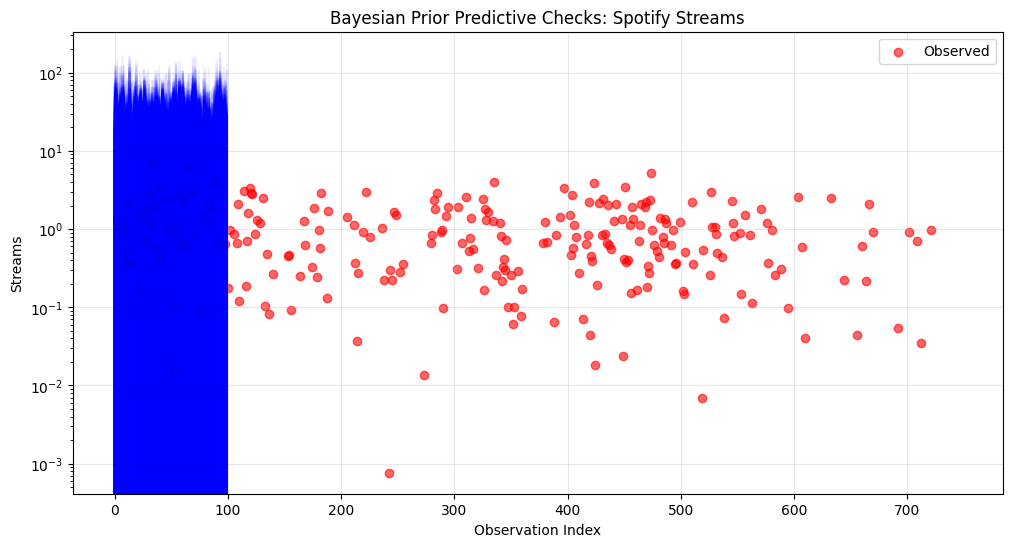

In [335]:
#prior predictive draws
prior_pred = prior_samples.prior_predictive["streams"].values  #shape: (n_draws, n_obs)

plt.figure(figsize=(12,6))

for i in range(min(100, prior_pred.shape[0])):  #plot at most 100 draws
    plt.plot(np.arange(prior_pred.shape[1]), prior_pred[i], color="blue", alpha=0.05)

#overlay observed data
plt.scatter(np.arange(len(y)), y_scaled.values, color="red", label="Observed", alpha=0.6)

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Bayesian Prior Predictive Checks: Spotify Streams")
plt.legend()
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

In [336]:
with multivar_weak_model:
    sample=pm.sample(random_seed=42,chains=2,draws=500,tune=500,cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 319 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

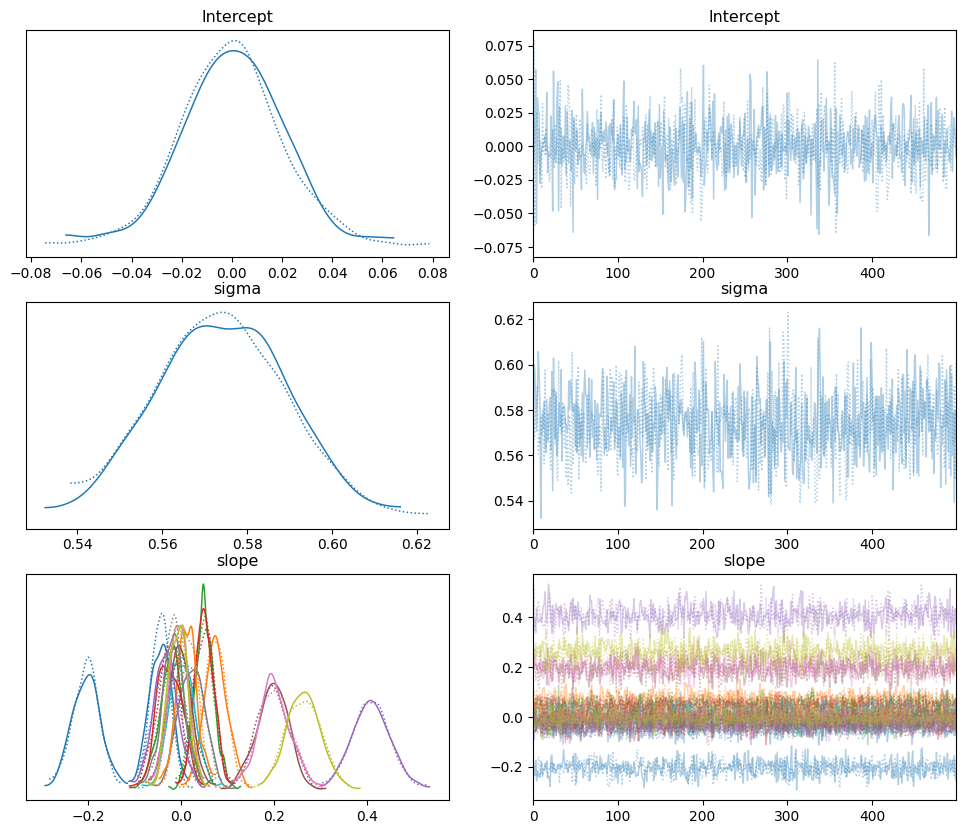

In [426]:
az.plot_trace(sample, var_names=["Intercept", "sigma", "slope"],figsize=(12,10))

Each of the densities on the left side plots look pretty similar to one another and converge to the same posterior distribution. Each of the trace plots on the right also seem to not have any general directional trend.

In [338]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.021,-0.036,0.041,0.001,0.001,1508.0,701.0,1.00
slope[artist_count],-0.045,0.022,-0.087,-0.006,0.001,0.001,1316.0,717.0,1.00
slope[released_year],0.074,0.024,0.028,0.120,0.001,0.001,1388.0,683.0,1.00
slope[released_month],0.049,0.022,0.010,0.093,0.001,0.001,1072.0,696.0,1.01
slope[released_day],0.049,0.021,0.009,0.085,0.001,0.001,1010.0,811.0,1.00
slope[in_spotify_playlists],0.408,0.040,0.331,0.483,0.001,0.001,902.0,721.0,1.00
slope[in_spotify_charts],0.196,0.034,0.133,0.260,0.001,0.001,899.0,792.0,1.00
slope[in_apple_playlists],0.201,0.035,0.134,0.266,0.001,0.001,881.0,645.0,1.00
slope[in_apple_charts],0.022,0.027,-0.027,0.070,0.001,0.001,1088.0,843.0,1.00
slope[in_deezer_playlists],0.263,0.037,0.194,0.332,0.001,0.001,772.0,657.0,1.00


Like in other analyses, the feature "in_spotify_playlists" seems to have the biggest posterior mean in bayesian linear regression. This makes sense since the number of streams is tracked on Spotify. However, the feature "in_shazam_charts" seem to be fairly sizeable and negative, which means that more shazam charts can result in less spotify streams. This could be because if that app is used more it can drive traffic away from Spotify, resulting in less streams, or some other interdependent reason.

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

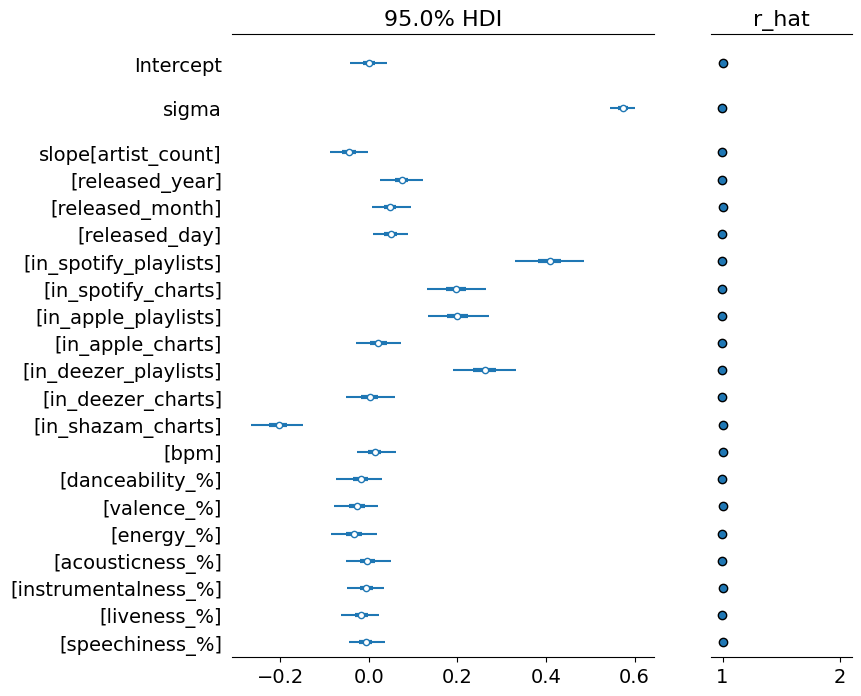

In [416]:
az.plot_forest(sample, var_names=["Intercept", "sigma", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

In [ ]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / x_mvar_numeric.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * x_mvar_numeric.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=x_mvar_numeric.columns)
posterior_df["Intercept"] = intercept_rescaled

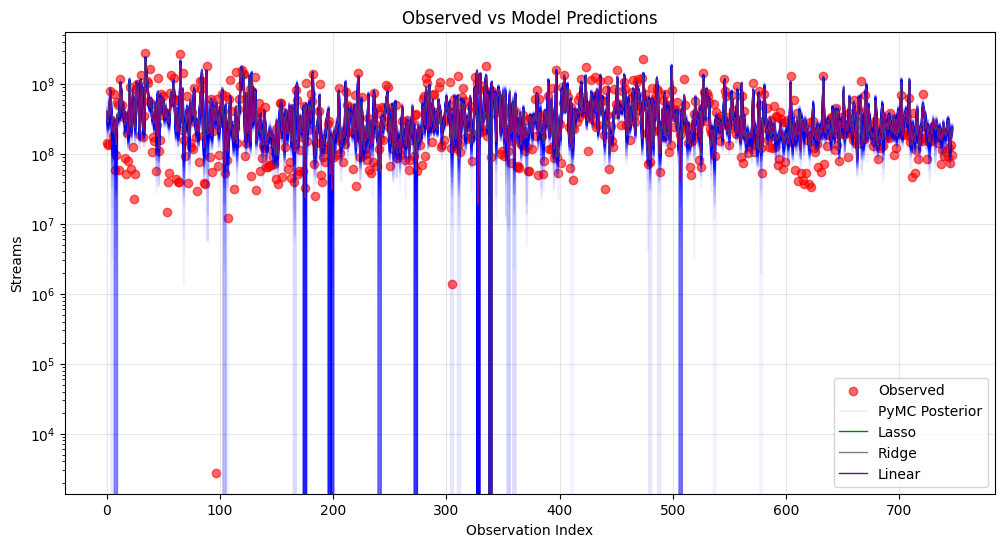

In [417]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(x_mvar_numeric.values, row[x_mvar_numeric.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(x_mvar_numeric)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


The regression models seem to line up with each other when plotted.

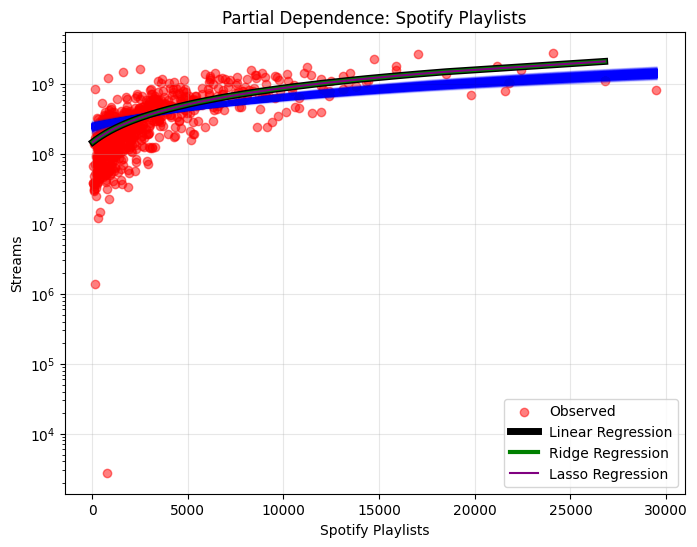

In [ ]:
"""
#choose a spotify range
x_feature = np.linspace(x_mvar_numeric["in_spotify_playlists"].min(),
                        x_mvar_numeric["in_spotify_playlists"].max(), 100)

#other features fixed at mean
X_fixed = x_mvar_numeric.mean().values  #shape: (n_features,)

#extract posterior slopes and intercepts
intercepts = posterior_df["Intercept"].values  #shape: (n_draws,)
slopes = posterior_df[x_mvar_numeric.columns].values  #shape: (n_draws, n_features)

plt.figure(figsize=(8,6))

#plot posterior predictive lines for the Spotify feature
for i in range(len(intercepts)):
    y_pred = intercepts[i] + slopes[i] @ X_fixed  #start with mean of other features
    #vary only Spotify playlists
    y_line = y_pred + slopes[i, x_mvar_numeric.columns.get_loc("in_spotify_playlists")] * (x_feature - X_fixed[x_mvar_numeric.columns.get_loc("in_spotify_playlists")])
    plt.plot(x_feature, y_line, color="blue", alpha=0.05)

#plot observed data for reference
plt.scatter(x_mvar_numeric["in_spotify_playlists"], y.values, color="red", alpha=0.5, label="Observed")

#regression lines from single-variable regression based on spotify playlists vs streams
plt.plot(X_test_sorted, y_pred_lin_sorted, color='black', label='Linear Regression',lw=5)
plt.plot(X_test_sorted, y_pred_ridge_sorted, color='green', label='Ridge Regression',lw=3)
plt.plot(X_test_sorted, y_pred_lasso_sorted, color='purple', label='Lasso Regression')

plt.xlabel("Spotify Playlists")
plt.ylabel("Streams")
plt.title("Partial Dependence: Spotify Playlists")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
"""

The graph shows

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if days of the week make an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if days of the week and key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

# Multivariate Regression

This portion of the analysis sees if the number of artists impacts the quality of prediction of streams based on musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

# Multivariate Regression

This portion of the analysis sees if the number of times songs appear in playlists impact the number of streams with musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.